# Create time series of snow cover over an area of interest using NDSI thresholding

__Requirements:__
- Area of Interest (AOI) geospatial file: shapefile, geopackage, or other file readable by geopandas
- Google Earth Engine account: sign up for a free account [here](https://code.earthengine.google.com/register).


In [1]:
import ee
import sys
import geopandas as gpd
import matplotlib.pyplot as plt

## Set up paths in directory

In [2]:
# Name of study site, used in output file names
site_name = "Banner"
# Path to the ndsi-snow-maps code
code_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/ndsi-snow-maps'
# Full path to area of interest
aoi_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/Banner/BannerBound_WGS84.shp'
# Path where snow maps will be saved
out_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/Banner/snow_maps'
# Path where figures will be saved
figures_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/Banner/snow_maps_figures'

# Authenticate and/or Initialize GEE 
# Change the project according to your GEE account, usually "ee-USERNAME" is your default project
try:
    ee.Initialize(project='ee-raineyaberle')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-raineyaberle')

# Add path to functions
sys.path.append(code_path)
import functions as f

/Users/raineyaberle/opt/anaconda3/envs/ndsi-snow-maps/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define search settings

In [3]:
# Define search settings (dates and months are inclusive)
start_date = '2018-05-01'
end_date = '2024-10-10'
start_month = 1
end_month = 12
mask_clouds = True  # whether to mask clouds before mapping snow
aoi_coverage = 70  # minimum coverage of the area of interest

## Load Area of Interest (AOI)

Optimal UTM CRS: 32611


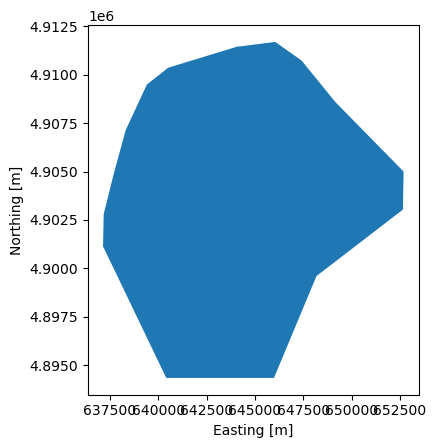

In [4]:
# Load AOI
aoi = gpd.read_file(aoi_path)
# Estimate optimal UTM CRS
aoi = aoi.to_crs('EPSG:4326') # reproject to WGS84 lat lon
crs_utm = f.convert_wgs_to_utm(lon=aoi.geometry[0].centroid.coords.xy[0][0], lat=aoi.geometry[0].centroid.coords.xy[1][0])
print('Optimal UTM CRS:', crs_utm)
# Reproject to optimal UTM zone
aoi_utm = aoi.to_crs(crs_utm)

# Plot 
aoi_utm.plot()
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.show()

## Query GEE for imagery, classify snow, and save to file

In [5]:
# Sentinel-2 Surface Reflectance
print('Sentinel-2 SR:\n----------')
f.query_imagery_classify_snow(aoi_utm, "Sentinel-2_SR", start_date, end_date, start_month, end_month,
                              aoi_coverage, out_path, figures_path, site_name, ndsi_threshold=0.4)

# Landsat 8/9
print('\nLandsat:\n----------')
f.query_imagery_classify_snow(aoi_utm, "Landsat", start_date, end_date, start_month, end_month, 
                              aoi_coverage, out_path, figures_path, site_name, ndsi_threshold=0.4)

print('DONE! :)')

Sentinel-2 SR:
----------
Made directory for outputs: /Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/Banner/snow_maps
Made directory for figures: /Users/raineyaberle/Research/PhD/snow_cover_mapping/Idaho_snow_maps_NDSI/Banner/snow_maps_figures
Querying GEE for Sentinel-2_SR images
Iterating over unique dates in collection


  0%|          | 1/844 [00:02<31:46,  2.26s/it]

Image only covers 0 % of the AOI, skipping


  0%|          | 2/844 [00:05<43:37,  3.11s/it]

Image only covers 22.34 % of the AOI, skipping


  0%|          | 3/844 [00:09<44:44,  3.19s/it]

Image only covers 0 % of the AOI, skipping


  0%|          | 4/844 [00:12<42:21,  3.03s/it]

Image only covers 0 % of the AOI, skipping


  1%|          | 5/844 [00:14<41:19,  2.96s/it]

Image only covers 0 % of the AOI, skipping


  1%|          | 5/844 [00:23<1:06:01,  4.72s/it]


EEException: Total request size (75794400 bytes) must be less than or equal to 50331648 bytes.

In [9]:
from shapely.geometry import Polygon

xmin, ymin, xmax, ymax = aoi_utm.geometry[0].bounds
aoi_bb = Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax], [xmin, ymin]])
aoi_bb.area

269747401.0549361

In [13]:
def check_for_image_download(aoi_utm, scale, num_bands, memory_limit_bytes=10e6, dtype='float64'):
    """
    Determine if an ee.Image exceeds the user memory limit and must be downloaded using geedim.

    Parameters
    ----------
    aoi_utm: geopandas.geodataframe.GeoDataFrame
        area of interest in UTM coordinates
    scale: int
        the output scale in meters (e.g., 30 for 30m resolution).
    num_bands: int
        number of bands in the ee.Image.
    memory_limit_bytes: int
        user memory limit in bytes.
    dtype: str
        data type of the image pixels (default 'float64').

    Returns
    ----------
    download: bool
        True if the estimated memory exceeds the limit, False otherwise.
    """
    # Get bounding box coordinates from the GeoDataFrame
    bounds = aoi_utm.total_bounds  # (minx, miny, maxx, maxy)
    # Calculate the width and height in meters
    width_meters = bounds[2] - bounds[0]
    height_meters = bounds[3] - bounds[1]
    # Calculate the number of pixels (width and height in pixels)
    width_pixels = width_meters / scale
    height_pixels = height_meters / scale
    # Total number of pixels
    total_pixels = width_pixels * height_pixels
    # Map data type to bytes per pixel
    dtype_size_map = {
        'float32': 4,  # 4 bytes per float32 value
        'float64': 8,  # 8 bytes per float64 value
        'int32': 4,    # 4 bytes per int32 value
        'int16': 2,    # 2 bytes per int16 value
        'uint8': 1     # 1 byte per uint8 value
    }
    # Get bytes per pixel for the specified dtype
    bytes_per_pixel = dtype_size_map.get(dtype, 4)  # Default to 4 bytes (float32)
    # Estimate the total image size in bytes
    estimated_size_bytes = total_pixels * num_bands * bytes_per_pixel
    print(estimated_size_bytes)
    # Check if it exceeds the memory limit
    download = bool(estimated_size_bytes > memory_limit_bytes)
    return download

check_for_image_download(aoi_utm, 30, 5, memory_limit_bytes=10e6, dtype='float32')


False